<a href="https://colab.research.google.com/github/Dominic-byte/Team-13-Regression-Predict/blob/master/Sendy_regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Team 13 Sendy Logistics Challenge

## Contents (finish sections 1, 3, 4, 5, 6, 7, 8, 9)

1. Introduction
2. Imports
3. Definitions
4. Data cleaning and preprocessing
5. Exploratoory data analysis
6. Feature engineering and selection
7. Model building
8. Results interpretation
9. Conclusion

## 1. Introduction

## 2. Imports

Packages

In [0]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
pd.options.display.max_columns = 60
sns.set_style("whitegrid")

Data

In [0]:
# URL to training and testing data
trurl = 'https://raw.githubusercontent.com/Dominic-byte/Team-13-Regression-Predict/master/Train.csv'
turl = 'https://raw.githubusercontent.com/Dominic-byte/Team-13-Regression-Predict/master/Test.csv'
rurl = 'https://raw.githubusercontent.com/Dominic-byte/Team-13-Regression-Predict/master/Riders.csv'
vurl = 'https://raw.githubusercontent.com/Dominic-byte/Team-13-Regression-Predict/master/VariableDefinitions.csv'

# Loading datasets
train_df = pd.read_csv(trurl, index_col=0)
test_df = pd.read_csv(turl, index_col=0)
riders_df = pd.read_csv(rurl, index_col=0)
variables = pd.read_csv(vurl, index_col=0)

# Storing variable names and test index
columns = train_df.columns
test_index = test_df.index

# Inspect data
print(train_df.shape, test_df.shape, riders_df.shape)
train_df.head(3)

(21201, 28) (7068, 24) (960, 4)


,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
Order No,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,9,5,10:04:47 AM,9,5,10:27:30 AM,9,5,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,12,5,11:40:22 AM,12,5,11:44:09 AM,12,5,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,12:42:44 PM,30,2,12:49:34 PM,30,2,12:53:03 PM,30,2,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455


## 3. Definitions

In [0]:
pd.options.display.max_colwidth = 0
variables

,Unique number identifying the order
Order No,
User Id,Unique number identifying the customer on a platform
Vehicle Type,"For this competition limited to bikes, however in practice Sendy service extends to trucks and vans"
Platform Type,"Platform used to place the order, there are 4 types"
Personal or Business,Customer type
Placement - Day of Month,Placement - Day of Month i.e 1-31
Placement - Weekday (Mo = 1),Placement - Weekday (Monday = 1)
Placement - Time,Placement - Time - Time of day the order was placed
Confirmation - Day of Month,Confirmation - Day of Month i.e 1-31
Confirmation - Weekday (Mo = 1),Confirmation - Weekday (Monday = 1)


In [0]:
pd.options.display.max_colwidth = 50

## 4. Data cleaning and preprocessing (BBP)

In [0]:
pd.merge(train_df, riders_df, how='left', on='Rider Id').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21201 entries, 0 to 21200
Data columns (total 32 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   User Id                                    21201 non-null  object 
 1   Vehicle Type                               21201 non-null  object 
 2   Platform Type                              21201 non-null  int64  
 3   Personal or Business                       21201 non-null  object 
 4   Placement - Day of Month                   21201 non-null  int64  
 5   Placement - Weekday (Mo = 1)               21201 non-null  int64  
 6   Placement - Time                           21201 non-null  object 
 7   Confirmation - Day of Month                21201 non-null  int64  
 8   Confirmation - Weekday (Mo = 1)            21201 non-null  int64  
 9   Confirmation - Time                        21201 non-null  object 
 10  Arrival at Pickup - Da

In [81]:
train_df['Distance (KM)'].describe()

count    21201.000000
mean         9.506533
std          5.668963
min          1.000000
25%          5.000000
50%          8.000000
75%         13.000000
max         49.000000
Name: Distance (KM), dtype: float64

### Data types
#### **Numerical**
- Ratio
  - *Number of Orders*
  - *Age*
  - *Number of Ratings*
  - *Time from pickup to arrival* - Target
- Interval
  - *Time (Placement, Confimation, Arrival, etc)* 
  - *Distance (KM)*
  - *Temperature*
  - *Precipitation*
  - *Co-ordinates*

#### **Categorical**
- Nominal
  - *User Id*
    - This is categorical as it only varies in the user that has\
      placed the order.
    - It may be possible to determine the frequency of orders\
      placed by customers and determine their loyalty. This may\
      reflect a drivers motivation to provide higher quality\
      service to that user.
  - *Vehicle Type*
    - The type of vehicle used would ordinarily have an impact on\
      delivery time as a motorcycle would be faster than a truck.
    - Since there is only one vehicle type to consider (bike)\
      there is no value to be gained from this data
  - *Platform Type*
    - The source of order placement is qualitative and may give\
      information about the level of service delivery for the\
      various platforms. More frequently used platforms may be\
      serviced better by drivers as they may provide a steady\
      stream of customers.
    - The platform can only take on the values from 1 to 4 and\
      should be stored as an `int16`
  - *Personal or Business*
    - Business orders are likely to be frequent and and located\
      near central business district, whereas personal orders\
      may require further travel to suburban areas. This could\
      have an effect on the travel time.
  - *Day of month (Placement, Confimation, Arrival, etc)*
    - The day of month can only vary in its quality. There may\
      more or less orders placed on a given day of the month.\
    - Since the values of day of month can take on values between\
      1 and 31 it would be most effecient to store it as an `int16`\
      instead of `int64` which is for larger numbers.
    - It may be that more orders are placed on certain days that\
      would result in longer delivery times.    
  - *Weekday*
    - Businesses typically operate on weekdays. It would logically\
      follow that weekdays are busier than weekends resulting in\
      longer delivery times due  to traffic or the volume of\
      orders.
    - Since the weekday is represented by 1 to 7, it should be\
      stored as an `int16`
    - *Rider Id*

- Ordinal
  - *Average rating*
    - Drivers are usually rated on a scale from one to 5. As a driver\
      recieves more ratings, the will begin to settle around their\
      true score. This score could reflect

### Cleaning functions

In [0]:
def data_preprocessing(df, na_thresh = 0, strategy = 'mean'):
  """Function that preprocesses data used for predictions and testing
  Parameters
  ----------
  df: DataFrame
          DataFrame to preprocess.
  na_thresh: float
          float between 0.0 and 1.0 specifying the drop/fillna
          threshhold
  strategy: string
          Filling strategy, 'mean', 'median' or  'rolling'
  Returns
  -------
  df: DataFrame
          Preprocessed DataFrame

  """
  cdf = df.copy()
  old = cdf.memory_usage().sum()
  # Create lists of columns to change
  integers = [col for col in cdf.columns if cdf[col].dtypes == 'int64']
  floats = [col for col in cdf.columns if cdf[col].dtypes == 'float64']
  time_cols = [col for col in cdf.columns if col.endswith("Time")]

  # Reduce size of data storage types
  cdf[integers] = cdf[integers].astype('int16')
  cdf[floats] = cdf[floats].astype('float16')
  for col in time_cols:
    cdf[col] = pd.to_datetime(cdf[col]).dt.time
  
  # Correcting specific columns
  if 'Distance (KM)' in cdf.columns:
    cdf['Distance (KM)'] = cdf['Distance (KM)'].astype('float16') 
  
  # Dropping NaN's
  for col in cdf.columns:
    missing = cdf[col].isnull().sum()/len(cdf)
    if missing > na_thresh:
      cdf.drop(columns=col, inplace=True)
  
  # Filling NaN's
  for col in cdf.columns:
    if cdf[col].isnull().sum() > 0:
      if cdf[col].dtypes == 'object':
        cdf[col].fillna(cdf[col].mode(), inplace=True) 
      elif strategy == 'mean':
        cdf[col].fillna(round(cdf[col].mean()), inplace=True)
      elif strategy == 'median':
        cdf[col].fillna(round(cdf[col].median()), inplace=True)
      elif strategy == 'rolling':
        cdf[col].fillna(cdf[col].rolling(7).mean(), inplace=True)
      else:
        raise ValueError

  new = cdf.memory_usage().sum()
  print("Bytes\t","\nOld:\t", str(old), "\nNew:\t", "("+str(new)+")", "\nSaved:\t", str(old - new))
  return cdf

In [0]:
%%capture [[--no-display]]
# Store transformations in EDA DataFrame
eda_df, test_clean, riders_clean = data_preprocessing(train_df, na_thresh = 0, strategy = 'mean'), data_preprocessing(test_df, na_thresh = 0, strategy = 'mean'), data_preprocessing(riders_df, na_thresh = 0, strategy = 'mean')

## 5. Data Exploration and preparation

a. Exploratory data analysis


In [0]:
columns = train_df.columns

1. Target - Time from Pickup to Arrival

In [0]:
# Setting variable for Target
target = columns[-1]

# Confirming the caluclation of the Target

Target = pd.to_datetime(train_df['Arrival at Destination - Time']) - pd.to_datetime(train_df['Pickup - Time'])
list(Target.dt.seconds[:]) == list(train_df[target][:])

True

In [0]:
eda_df[target].describe()

count    21201.000000
mean      1556.920947
std        987.270788
min          1.000000
25%        882.000000
50%       1369.000000
75%       2040.000000
max       7883.000000
Name: Time from Pickup to Arrival, dtype: float64

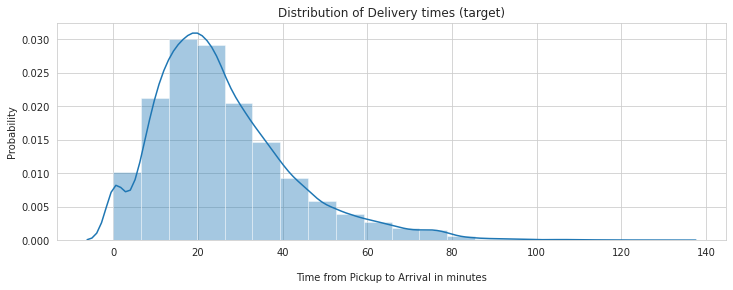

In [0]:
# Histogram
fig = plt.figure(figsize=(12,4))
sns.distplot(eda_df[target]/60, bins =20)
plt.title('Distribution of Delivery times (target)')
plt.xlabel('\n'+target+' in minutes')
plt.ylabel("Probability")
plt.show()

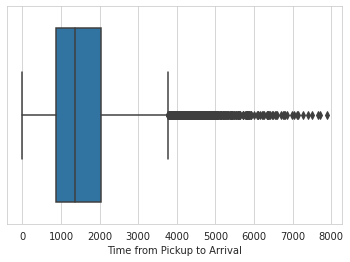

In [0]:
# Outliers

sns.boxplot(x=target,data=eda_df)

quick notes
 - majority of trips are arund 2000 seconds

2. Univariate analysis (D)

3. Bivariate analysis (AB)

5. Remove Collinearity (HELPER FUNCTIONS)
6. Missing values treatment (HELPER FUNCTIONS)
7. Outlier treatment (HELPER FUNCTIONS)

b. Feature engineering and selection


1. Variable transformation

2. Variable creation

### 6. Model building

## 6. Results interpretation

## 7. Conclusion